In [1]:
import torchvision
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm
import torch
import ImageData
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time

In [2]:
model_name = "resnet"
model_image_size = 224
# vit = models.vit_l_16(models.ViT_L_16_Weights.IMAGENET1K_V1)

In [3]:
class ResNet(torch.nn.Module):
    def __init__(self, numClasses: int, softmax:bool = True):
        super(ResNet, self).__init__()

        self.resnet = torchvision.models.resnet152(weights='DEFAULT')
        for param in list(self.resnet.parameters())[:-1]:
            param.requires_grad = False

        self.resnet.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 216),
            torch.nn.ReLU(),
            torch.nn.Linear(216, 4)
        )
        
        
        # for param in self.inceptionBase.parameters():
        #     print(param.requires_grad)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        out = self.resnet(x)
        return out

In [4]:
model = ResNet(4).to(device)
# print(*list(model.children())[:-1])

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\wiggle_jiggle/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:07<00:00, 31.8MB/s] 


In [5]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainDataLoader, validDataLoader, testDataLoader = ImageData.getImagesDataloaders("./ArtiFact/", transforms = transform, batchSize=batch_size)

In [7]:
def evaluate_on_data(model, dataloader, dirty: bool = False):
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_samples = 0.0
        for data in tqdm(dataloader, desc="Eval: "):
            image, label = data
            label = label.to(device)
            image = image.to(device)
            outputs = model(image)
            if dirty:
                label = torch.where(label > 1, torch.tensor(1, dtype = torch.int32).to(device), label)


            loss = criterion(outputs, label)
            total_loss += loss.item()
            argMax = torch.argmax(outputs, 1)
            for i in range(len(label)):
                if label[i] == argMax[i]:
                    num_correct += 1

                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples

In [8]:
num_epochs = 10
count = 0
valid_loss_array = np.zeros(num_epochs)
valid_acc_array = np.zeros(num_epochs)
valid_acc_dirty_array = np.zeros(num_epochs)

train_loss_array = np.zeros(num_epochs)
for epoch in range(num_epochs):
    batch_count = 0
    for data in tqdm(trainDataLoader, desc="Training: "):
        
        image, label = data
        
        label = label.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        count += 1
        # print(loss)
            
        
    valid_loss, valid_acc = evaluate_on_data(model, validDataLoader)
    _, valid_acc_dirty = evaluate_on_data(model, validDataLoader, dirty=True)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}, Dirty Valid ACC: {valid_acc_dirty}')
    valid_loss_array[epoch] = valid_loss
    train_loss_array[epoch] = loss.item()
    valid_acc_array[epoch] = valid_acc
    valid_acc_dirty_array[epoch] = valid_acc


Training:   0%|          | 0/116172 [00:00<?, ?it/s]

Training:   1%|          | 1110/116172 [01:15<2:07:47, 15.01it/s]

In [ ]:
with open(model_name + '_valid_loss.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    
with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)

with open(model_name + '_valid_dirty_acc.npy', 'wb') as f:
    np.save(f, valid_acc_dirty_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

In [ ]:
import matplotlib.pyplot as plt

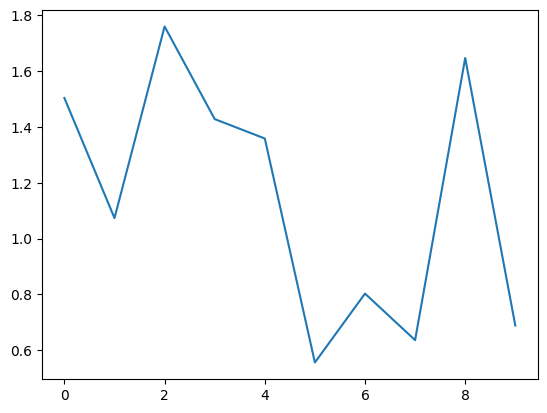

In [ ]:
plt.plot(train_loss_array)

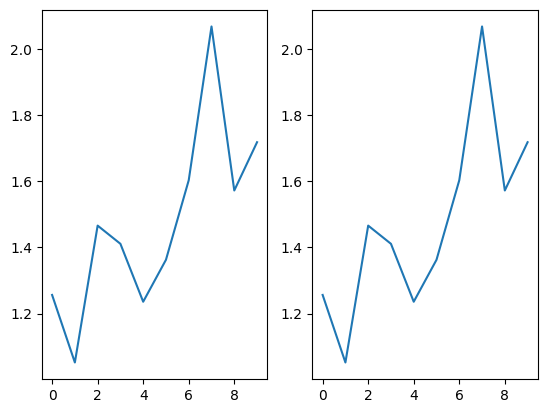

In [ ]:
figure, axis = plt.subplots(1,2)
axis[0].plot(valid_loss_array)
axis[1].plot(valid_loss_dirty_array)